In [1]:
!pip install tensorflow

In [2]:
# Importamos las librerías
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import openpyxl
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from scipy import sparse

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="prophet.plot")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Ruta de los datos
df1 = pd.read_excel('/Users/fernandopradagorge/Documents/Documentos - MacBook Pro de Fernando/Universidad/Master Data Science and AI/Nuclio Projects/Projects/Evolución ventas vehículos particulares/Lista detallada de ventas.xlsx')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   V                      7906 non-null   object        
 1   Fecha                  7904 non-null   datetime64[ns]
 2   V/A                    7904 non-null   object        
 3   IDV                    7904 non-null   float64       
 4   Origen                 7904 non-null   object        
 5   Referencia             7904 non-null   float64       
 6   Tipo Vehículo          7686 non-null   object        
 7   Matricula              7814 non-null   object        
 8   Marca                  7904 non-null   object        
 9   Modelo                 7904 non-null   object        
 10  Canal                  7904 non-null   object        
 11  Facturación            7905 non-null   float64       
 12  Facturación (media)    7905 non-null   float64       
 13  Imp

In [ ]:
df1.head()

,V,Fecha,V/A,IDV,Origen,Referencia,Tipo Vehículo,Matricula,Marca,Modelo,...,Cambio,Kilómetros,Fecha Matric.,Segmento,SubSegmento,Importe Remarketing,Margen I,Margen II,Margen III,Margen IV
0,1,2024-01-18,V,156385.0,VO,31114932.0,MOTOS,6457GSW,PIAGGIO,PIAGGIO VESPA 50CC,...,AUTOMATICO,72940.0,2010-01-18,NaN,NaN,0.00,82.65,82.65,-48.56,-48.56
1,1,2023-03-21,V,156385.0,VO,28637837.0,MOTOS,6457GSW,PIAGGIO,PIAGGIO VESPA 50CC,...,AUTOMATICO,72940.0,2010-01-18,NaN,NaN,0.00,413.22,413.22,476.84,476.84
2,1,2023-06-29,V,159474.0,VO,29507497.0,TURISMOS,5383GTM,FORD,FOCUS,...,MANUAL,124380.0,2010-02-22,Turismos,Segmento C,0.00,991.73,991.73,855.35,855.35
3,1,2024-03-18,V,200955.0,VO,31567110.0,TURISMOS,4134HSR,OPEL,OPEL CORSA,...,MANUAL,106772.0,2013-08-29,Turismos,Segmento B,1347.61,4123.97,4123.97,2861.92,2861.92
4,1,2023-01-16,V,205707.0,VO,28058110.0,TURISMOS,1962HTZ,ALFA,GIULIETTA,...,MANUAL,66511.0,2013-12-18,Turismos,Segmento C,0.00,2300.51,2300.51,1618.87,1618.87


### EDA

In [ ]:
df1.columns

Index(['V', 'Fecha', 'V/A', 'IDV', 'Origen', 'Referencia', 'Tipo Vehículo',
       'Matricula', 'Marca', 'Modelo', 'Canal', 'Facturación',
       'Facturación (media)', 'Importe Venta (media)', 'Margen', 'Financiado',
       'Imp. Financiado', 'Interés', 'Financiera', 'NumeroCuotas',
       'Concesionario', 'Vendedor', 'Comprador', 'Días en Stock', 'Bastidor',
       'Combustible', 'Cambio', 'Kilómetros', 'Fecha Matric.', 'Segmento',
       'SubSegmento', 'Importe Remarketing', 'Margen I', 'Margen II',
       'Margen III', 'Margen IV'],
      dtype='object')

In [ ]:
df1 = df1.drop(['Referencia', 'Canal', 'Matricula', 'Financiado', 'Imp. Financiado', 'Interés', 'Financiera', 'NumeroCuotas', 'Vendedor', 'Comprador', 'Bastidor', 'Kilómetros', 'V', 'V/A', 'IDV', 'Margen I', 'Margen II', 'Margen III', 'Margen IV', 'Segmento', 'SubSegmento', 'Fecha Matric.', 'Cambio', 'Días en Stock', 'Importe Remarketing', 'Margen'], axis = 1)

In [ ]:
df1.columns

Index(['Fecha', 'Origen', 'Tipo Vehículo', 'Marca', 'Modelo', 'Facturación',
       'Facturación (media)', 'Importe Venta (media)', 'Concesionario',
       'Combustible'],
      dtype='object')

In [ ]:
df2 = df1.copy()

In [ ]:
df2.columns

Index(['Fecha', 'Origen', 'Tipo Vehículo', 'Marca', 'Modelo', 'Facturación',
       'Facturación (media)', 'Importe Venta (media)', 'Concesionario',
       'Combustible'],
      dtype='object')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha                  7904 non-null   datetime64[ns]
 1   Origen                 7904 non-null   object        
 2   Tipo Vehículo          7686 non-null   object        
 3   Marca                  7904 non-null   object        
 4   Modelo                 7904 non-null   object        
 5   Facturación            7905 non-null   float64       
 6   Facturación (media)    7905 non-null   float64       
 7   Importe Venta (media)  7905 non-null   float64       
 8   Concesionario          7904 non-null   object        
 9   Combustible            7224 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 617.9+ KB


In [ ]:
df2 = df2.drop(['Concesionario', 'Tipo Vehículo'], axis = 1)

In [ ]:
df2.isnull().sum()

Fecha                      3
Origen                     3
Marca                      3
Modelo                     3
Facturación                2
Facturación (media)        2
Importe Venta (media)      2
Combustible              683
dtype: int64

In [ ]:
# Eliminar los 3 nulos de la columna 'Fecha' ya que no son significativos para el modelo
df2.dropna(subset = ['Fecha'], inplace = True)

In [ ]:
# Establecer la columan 'Fecha' como índice 
df2.set_index('Fecha', inplace = True)

In [ ]:
# Usar 'Facturación' como ventas 
df2['Facturación'] = df2['Facturación'].astype(float)

In [ ]:
# Agrupar las ventas por mes y luego sumar las ventas en cada mes
monthly_sales = df2[['Facturación']].resample('M').sum()

/var/folders/hn/58jsz1wd6jn8ypqlsj_ym3sc0000gn/T/ipykernel_32988/4269605706.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df2[['Facturación']].resample('M').sum()


In [ ]:
# Crear un DataFrame de rango diario basado en el índice mensual
daily_sales = monthly_sales.resample('D').asfreq()

In [ ]:
# Redistribuir las ventas mensuales en ventas diarias
daily_sales['Ventas diarias'] = daily_sales['Facturación'] / daily_sales['Facturación'].groupby(pd.Grouper(freq = 'M')).transform('count')
daily_sales.fillna(0, inplace = True)

/var/folders/hn/58jsz1wd6jn8ypqlsj_ym3sc0000gn/T/ipykernel_32988/2617258642.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_sales['Ventas diarias'] = daily_sales['Facturación'] / daily_sales['Facturación'].groupby(pd.Grouper(freq = 'M')).transform('count')


### Imputación de valores nulos

In [ ]:
# Definir las transformaciones para las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', MinMaxScaler())
])

In [ ]:
# Definir las transfformaciones para las columnas categórica
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown ='ignore'))
])

In [ ]:
# Crear el transformador de columnas usando el ColumnTransform
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, df2.select_dtypes(include=['float64', 'int64']).columns),
    ('cat', categorical_transformer, df2.select_dtypes(include=['object']).columns)
])

In [ ]:
# Crear la pipeline
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor)
])

In [ ]:
# Aplicar el pipeline al DataFrame
df2_transformed = pipeline.fit_transform(df2)

In [ ]:
print("Forma del DataFrame transformado:", df2_transformed.shape)

Forma del DataFrame transformado: (7904, 431)


In [ ]:
category_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out()
new_columns = list(df2.select_dtypes(include=['float64', 'int64']).columns) + list(category_columns)

In [ ]:
print("Verificación final antes de crear el DataFrame:")
print("Forma del df2_transformed:", df2_transformed.shape)
print("Dimensiones esperadas de new_columns:", len(new_columns))

Verificación final antes de crear el DataFrame:
Forma del df2_transformed: (7904, 431)
Dimensiones esperadas de new_columns: 431


In [ ]:
# Convertir la matriz dispersa a una matriz densa si es necesario
if sparse.issparse(df2_transformed):
    print("Converting sparse matrix to dense matrix...")
    df2_transformed = df2_transformed.toarray()

if df2_transformed.shape[1] == len(new_columns):
    df2_final = pd.DataFrame(df2_transformed, index=df2.index, columns=new_columns)
    print("DataFrame final creado con éxito:")
    print(df2_final.head())
else:
    print("Incongruencia en el número de columnas:", df2_transformed.shape[1], "esperado:", len(new_columns))


Converting sparse matrix to dense matrix...
DataFrame final creado con éxito:
            Facturación  Facturación (media)  Importe Venta (media)  x0_KM0  \
Fecha                                                                         
2024-01-18     0.380065             0.009954               0.008965     0.0   
2023-03-21     0.378384             0.007269               0.006546     0.0   
2023-06-29     0.386024             0.019470               0.018843     0.0   
2024-03-18     0.409839             0.057503               0.051786     0.0   
2023-01-16     0.424827             0.081440               0.073342     0.0   

            x0_VN  x0_VO  x1_ABARTH  x1_ALFA  x1_APRILIA  x1_AUDI  ...  \
Fecha                                                              ...   
2024-01-18    0.0    1.0        0.0      0.0         0.0      0.0  ...   
2023-03-21    0.0    1.0        0.0      0.0         0.0      0.0  ...   
2023-06-29    0.0    1.0        0.0      0.0         0.0      0.0  ...  

In [ ]:
df2_final.head()

,Facturación,Facturación (media),Importe Venta (media),x0_KM0,x0_VN,x0_VO,x1_ABARTH,x1_ALFA,x1_APRILIA,x1_AUDI,...,x2_ZONTES,x2_ZS,x3_1.0 Ecoboost 100cv,x3_DIESEL,x3_ELECTRICO,x3_GASOLINA,x3_HIBRIDO,x3_HIBRIDO ENCHUFABLE,x3_MICROHIBRIDO,x3_MICROHIBRIDO DIESEL
Fecha,,,,,,,,,,,,,,,,,,,,,
2024-01-18,0.380065,0.009954,0.008965,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-03-21,0.378384,0.007269,0.006546,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2023-06-29,0.386024,0.019470,0.018843,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-03-18,0.409839,0.057503,0.051786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-16,0.424827,0.081440,0.073342,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preparación de Prophet

In [ ]:
# Preparar DF para el Prophet
# Asumiendo que la columna 'Facturación' es un buen representante de las ventas de coches
df_prophet = daily_sales.reset_index().rename(columns = {'Fecha': 'ds', 'Ventas diarias': 'y'})

In [ ]:
df_prophet.columns

Index(['ds', 'Facturación', 'y'], dtype='object')

In [ ]:
# Inicializar el modelo de Prophet
# Se activan lad tendencias, diarias, semanales y anuales
model = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False)

In [ ]:
# Añadir las festividades de España
model.add_country_holidays(country_name = 'ES')

In [ ]:
# Ajustar el modelo
df_prophet = df2_final.reset_index().rename(columns = {'Fecha': 'ds', 'Facturación': 'y'})
model.fit(df_prophet[['ds', 'y']])

23:05:32 - cmdstanpy - INFO - Chain [1] start processing


23:05:34 - cmdstanpy - INFO - Chain [1] done processing


### Predicciones futuras

In [ ]:
# Crear el DataFrame para predicciones futuras
future = model.make_future_dataframe(periods = 60)

In [ ]:
# Realizar las predicciones
forecast = model.predict(future)

### Gráficos

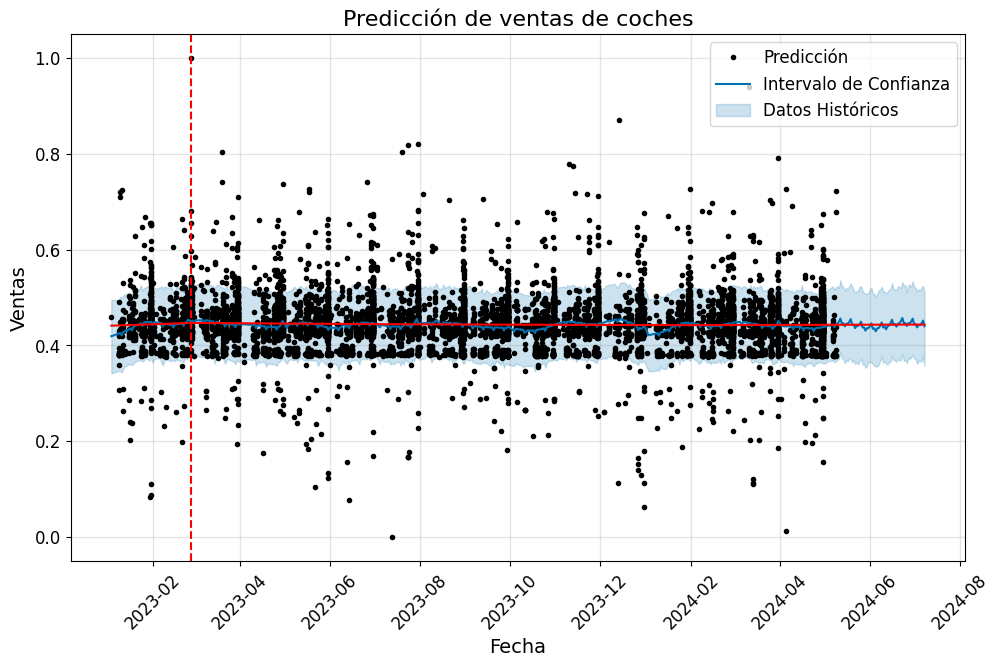

In [ ]:
# Visualizar las predicciones
fig = model.plot(forecast, figsize = (10, 6))

a = add_changepoints_to_plot(fig.gca(), model, forecast)

ax = fig.gca()
ax.set_title('Predicción de ventas de coches', fontsize = 16)
ax.set_xlabel('Fecha', fontsize = 14)
ax.set_ylabel('Ventas', fontsize = 14)
ax.tick_params(axis = 'x', labelrotation = 45)
ax.tick_params(axis = 'both', labelsize = 12)

# Leyenda
ax.legend(['Predicción', 'Intervalo de Confianza', 'Datos Históricos'], fontsize = 12)

plt.show()

## Predicción de Ventas de Coches

El gráfico muestra la predicción de ventas de coches basada en el modelo Prophet, desglosando las ventas reales en comparación con las predicciones futuras.

### Componentes del Gráfico

- **Puntos Negros**: Representan los datos históricos de ventas de coches. Cada punto es una observación de las ventas en un día específico, resultante de la redistribución de las ventas mensuales en valores diarios.

- **Línea Azul**: Esta línea muestra la tendencia central de las predicciones del modelo. La línea sigue la tendencia deducida de los datos históricos desagregados y proyecta esta tendencia hacia el futuro.

- **Área Azul Clara**: Denota el intervalo de confianza de las predicciones. Esta área sombreada muestra dónde el modelo predice que las ventas reales podrían variar, con una probabilidad del 80% (o cualquier otro porcentaje configurado) de que las ventas reales estén dentro de este rango.

- **Línea Roja Punteada**: Indica el punto en el tiempo donde el modelo comienza a hacer predicciones basadas en el análisis de los datos históricos. Las fechas a la izquierda son datos históricos, mientras que a la derecha están las proyecciones futuras.

### Escala del Eje Y

La escala del eje y está en valores absolutos de ventas diarias. Esta representación facilita la interpretación directa de las ventas diarias proyectadas, permitiendo una evaluación clara de la tendencia y la estacionalidad sin necesidad de normalización. Mantener los valores absolutos ayuda a visualizar la variación real en las ventas y a entender mejor los cambios proyectados en contextos específicos de tiempo.

### Interpretación

El modelo sugiere una tendencia generalmente estable en las ventas diarias de coches con fluctuaciones menores a lo largo del tiempo. La predicción indica que esta tendencia se mantendrá en el futuro cercano, aunque con variaciones que reflejan la estacionalidad y otros factores influyentes detectados por el modelo. La redistribución diaria permite una predicción más suave y detallada.

### Uso Estratégico

Estas predicciones son vitales para la planificación estratégica en marketing y operaciones. Por ejemplo, el equipo de marketing puede usar esta información para planear campañas dirigidas durante períodos de alta demanda proyectada. Igualmente, la gestión de inventario puede ser optimizada para asegurar que la oferta coincida con la demanda esperada, maximizando así la eficiencia y la rentabilidad.

### Conclusión

El análisis predictivo, como el mostrado en este gráfico, proporciona una herramienta esencial para anticipar cambios en el mercado y ajustar las estrategias empresariales de manera proactiva. La desagregación de las ventas mensuales en valores diarios permite una predicción más precisa y útil, facilitando una planificación más detallada y ajustada a las necesidades del mercado. Esta capacidad de anticipar el futuro basándose en datos pasados permite a la empresa mantenerse competitiva y alineada con las tendencias del mercado.

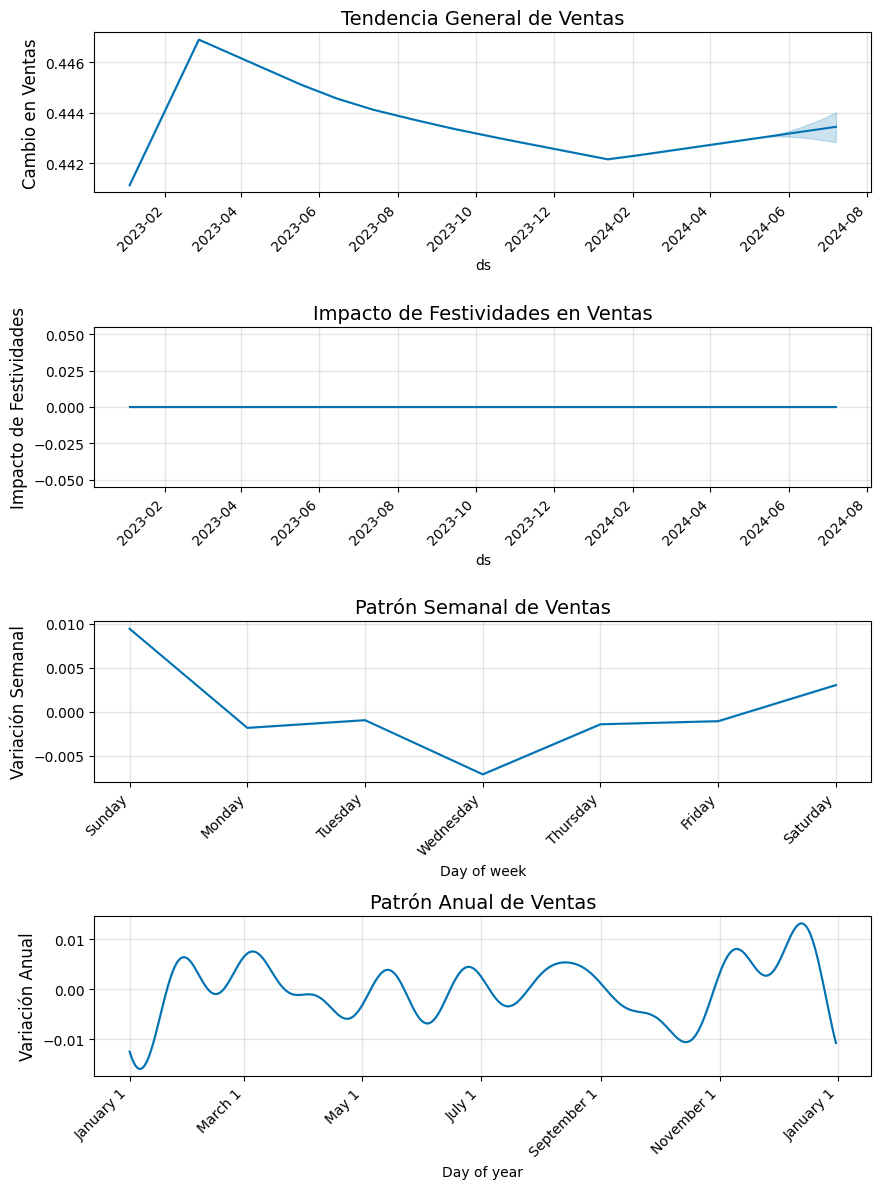

In [ ]:
# Generar la figura con los componentes del modelo
fig2 = model.plot_components(forecast)
axes = fig2.get_axes()

# Cambiar las etiquetas del eje y para cada gráfico
axes[0].set_ylabel('Cambio en Ventas', fontsize=12)  # Tendencia
axes[1].set_ylabel('Impacto de Festividades', fontsize=12)  # Festividades
axes[2].set_ylabel('Variación Semanal', fontsize=12)  # Estacionalidad Semanal
axes[3].set_ylabel('Variación Anual', fontsize=12)  # Estacionalidad Anual

# Ajustar el título para cada gráfico
axes[0].set_title('Tendencia General de Ventas', fontsize=14)
axes[1].set_title('Impacto de Festividades en Ventas', fontsize=14)
axes[2].set_title('Patrón Semanal de Ventas', fontsize=14)
axes[3].set_title('Patrón Anual de Ventas', fontsize=14)

# Rotar las etiquetas del eje x donde sea necesario
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# Ajustar el espacio para evitar solapamientos
plt.tight_layout()

# Mostrar la figura
plt.show()

## Análisis Detallado de Componentes de las Ventas de Coches

A continuación, se presenta un desglose de los diferentes componentes que afectan las predicciones de ventas de coches, utilizando el modelo Prophet. Cada gráfico proporciona insights sobre distintos factores que influyen en las tendencias de ventas.

### Tendencia General de Ventas

- **Gráfico Superior**: Este gráfico muestra la tendencia subyacente en las ventas de coches a lo largo del tiempo. Podemos observar una tendencia generalmente constante con una ligera disminución a mediados del período observado. La sombra azul alrededor de la línea de tendencia muestra el intervalo de confianza, lo que indica dónde se espera que fluctúen las ventas con una cierta probabilidad.

### Impacto de Festividades en Ventas

- **Segundo Gráfico**: Representa el impacto estimado de las festividades en las ventas de coches. Este componente muestra cómo días específicos, como festivos nacionales o locales, pueden influir en las ventas. La línea horizontal indica la ausencia de un impacto significativo de festividades en la mayoría de los períodos, con excepciones en fechas particulares que requieren una investigación adicional para identificar eventos específicos.

### Patrón Semanal de Ventas

- **Tercer Gráfico**: Muestra cómo varían las ventas de coches a lo largo de la semana. Este análisis es crucial para optimizar la fuerza laboral y las campañas de marketing en días específicos de la semana que muestran mayores ventas, como se observa hacia el final de la semana.

### Patrón Anual de Ventas

- **Último Gráfico**: Ilustra la estacionalidad anual de las ventas de coches. Claramente visible, las ventas fluctúan significativamente a lo largo del año, lo cual es vital para la planificación de la producción y las actividades promocionales. Los picos y valles pueden corresponder a temporadas de compras altas y bajas, influenciadas por factores económicos, climáticos y sociales.

### Explicación de la Escala del Eje Y

En todos los gráficos, el eje y representa una medida normalizada o ajustada de las ventas, lo que permite una comparación más fácil entre diferentes periodos o componentes sin ser afectada por la magnitud absoluta de las ventas. Esta escala es particularmente útil para visualizar y comparar las variaciones relativas y tendencias dentro de los datos, independientemente del volumen total de ventas. Utilizar esta escala normalizada ayuda a identificar los patrones más claramente y a hacer inferencias más precisas sobre el comportamiento de las ventas a lo largo del tiempo.

### Conclusión

El entendimiento detallado de estos componentes ayuda a los equipos de marketing y ventas a desarrollar estrategias más informadas y eficaces. Al anticipar las tendencias y ajustarse a los patrones de compra observados, la empresa puede mejorar significativamente su alcance en el mercado y optimizar sus recursos de manera efectiva.

### Predicciones para Mayo y Junio de 2024

In [ ]:
mask = (forecast['ds'] >= '2024-05-01') & (forecast['ds'] <= '2024-06-30')
may_june_forecast = forecast.loc[mask]

In [ ]:
# Cálculo del porcentaje de cambio diario en la predicción
may_june_forecast['percent_change'] = may_june_forecast['yhat'].pct_change() * 100

/var/folders/hn/58jsz1wd6jn8ypqlsj_ym3sc0000gn/T/ipykernel_32988/2659897296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may_june_forecast['percent_change'] = may_june_forecast['yhat'].pct_change() * 100


In [ ]:
# Limpiar los datos del gráfico para eliminar los posibles NaN que hubierann surgido del cálculo anterior
may_june_forecast = may_june_forecast.dropna(subset=['percent_change'])

In [ ]:
# Preparar el gráfico
plot_data = may_june_forecast[['ds', 'percent_change']]

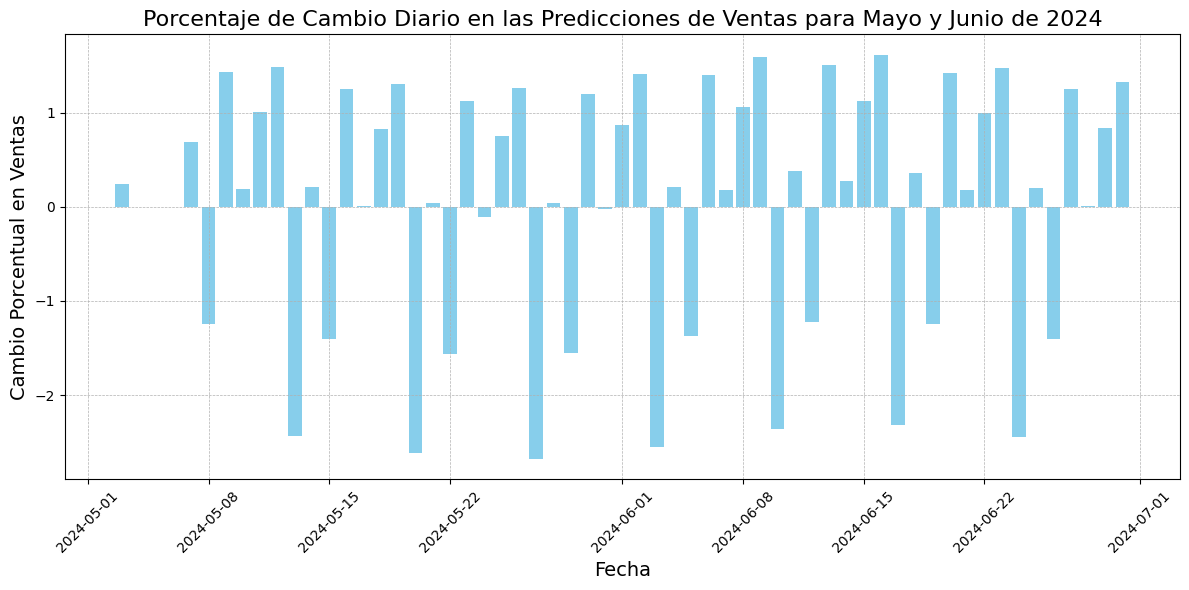

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(plot_data['ds'], plot_data['percent_change'], color='skyblue')

# Añadir etiquetas y título al gráfico
plt.title('Porcentaje de Cambio Diario en las Predicciones de Ventas para Mayo y Junio de 2024', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cambio Porcentual en Ventas', fontsize=14)

# Mejorar el formato de la fecha en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Porcentaje de Cambio Diario en las Predicciones de Ventas para Mayo y Junio de 2024

El gráfico muestra el porcentaje de cambio diario en las predicciones de ventas de coches para los meses de Mayo y Junio de 2024. Este análisis es crucial para entender la volatilidad diaria en las ventas previstas y ajustar las estrategias operativas y de marketing en consecuencia.

### Componentes del Gráfico

- **Eje X (Fecha)**: Representa los días de Mayo y Junio de 2024. Cada barra en el gráfico corresponde a un día específico dentro de este período.

- **Eje Y (Cambio Porcentual en Ventas)**: Indica el porcentaje de cambio en las ventas diarias comparado con el día anterior. Un valor positivo significa un aumento en las ventas, mientras que un valor negativo indica una disminución.

### Análisis del Gráfico

- **Variabilidad Diaria**: Observamos una significativa variabilidad diaria en las predicciones de ventas. Hay días con aumentos notables en las ventas seguidos de días con disminuciones. Esta fluctuación sugiere que las ventas diarias pueden ser altamente volátiles, lo que podría estar influenciado por diversos factores como campañas de marketing, eventos estacionales o económicos.

- **Picos y Valles**: Los picos representan días con un incremento significativo en las ventas diarias, mientras que los valles indican días con una disminución considerable. Por ejemplo, al inicio de Mayo y durante la primera semana de Junio se observan varios picos y valles.

### Implicaciones para Negocio y Marketing

- **Planificación de Campañas**: Los días con incrementos significativos pueden indicar oportunidades para fortalecer las campañas de marketing. Identificar patrones específicos en estos incrementos puede ayudar a planificar mejor las promociones y descuentos.

- **Gestión de Inventarios**: La volatilidad en las ventas diarias requiere una gestión de inventarios más dinámica. Estar preparados para las fluctuaciones puede evitar situaciones de exceso o falta de stock.

- **Ajuste de Estrategias**: Comprender los factores que causan estas variaciones puede llevar a ajustes estratégicos en el calendario de lanzamientos de productos, promociones y otras iniciativas de negocio.

### Conclusión

El gráfico de porcentaje de cambio diario proporciona una visión detallada de la volatilidad en las ventas de coches para Mayo y Junio de 2024. Este análisis permite a los equipos de negocio y marketing anticipar cambios y ajustar sus estrategias para optimizar el rendimiento y la eficiencia. Utilizar esta información puede ayudar a maximizar las oportunidades de ventas y mejorar la gestión de recursos.

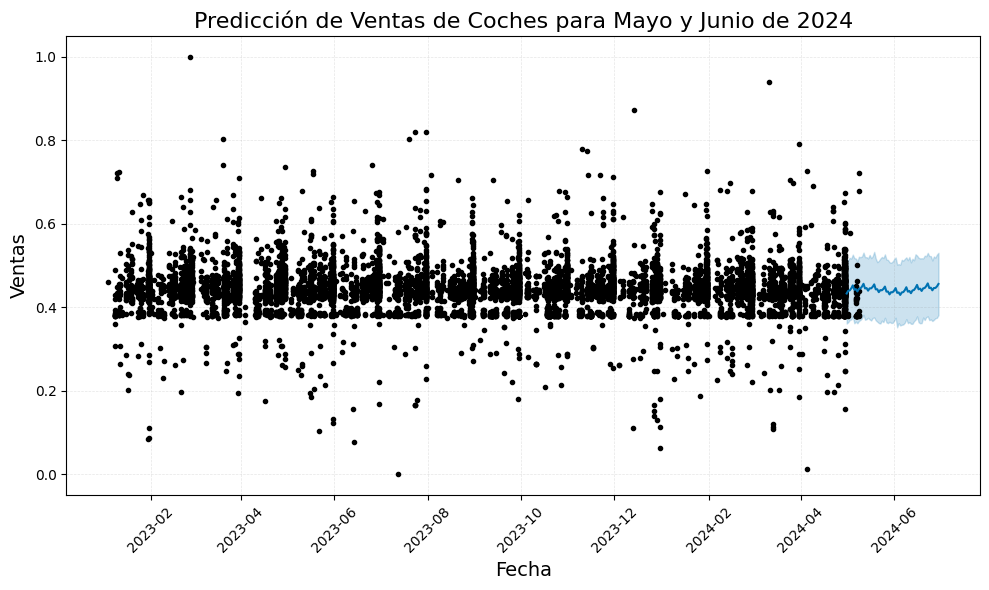

In [ ]:
# Crear un DataFrame con las fechas específicas de mayo y junio de 2024
start_date = '2024-05-01'
end_date = '2024-06-30'
future_dates = pd.date_range(start=start_date, end=end_date)
future_df = pd.DataFrame({'ds': future_dates})

# Predecir las ventas para esas fechas
forecast = model.predict(future_df)

# Visualizar las predicciones para mayo y junio de 2024
fig = model.plot(forecast)
plt.title('Predicción de Ventas de Coches para Mayo y Junio de 2024', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Ventas', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Predicción de Ventas de Coches para Mayo y Junio de 2024

El gráfico muestra la predicción de ventas de coches específicamente para los meses de Mayo y Junio de 2024, utilizando el modelo Prophet.

### Componentes del Gráfico

- **Puntos Negros**: Representan los datos históricos de ventas diarias de coches. Cada punto es una observación de las ventas en un día específico.

- **Línea Azul**: Esta línea muestra la tendencia central de las predicciones del modelo para los meses de Mayo y Junio de 2024. La línea sigue la tendencia deducida de los datos históricos y proyecta esta tendencia hacia el futuro.

- **Área Azul Clara**: Denota el intervalo de confianza de las predicciones para Mayo y Junio de 2024. Esta área sombreada muestra dónde el modelo predice que las ventas reales podrían variar, con una probabilidad del 80% de que las ventas reales estén dentro de este rango.

### Análisis del Gráfico

- **Tendencia General**: La línea azul que representa la tendencia central sugiere una estabilidad en las ventas diarias de coches durante los meses de Mayo y Junio de 2024. No se observan cambios drásticos en la tendencia proyectada, lo que indica una continuidad de la tendencia observada en los datos históricos.

- **Volatilidad Diaria**: Los puntos negros muestran la variabilidad diaria en las ventas históricas. Aunque existe una variabilidad significativa en los datos históricos, la predicción proyecta una tendencia más suavizada.

- **Intervalo de Confianza**: El área azul clara alrededor de la línea de tendencia central ofrece una indicación del grado de incertidumbre en las predicciones. Un intervalo de confianza más estrecho sugiere una mayor certeza en las predicciones del modelo.

### Implicaciones para Negocio y Marketing

- **Planificación de Campañas**: La estabilidad en la tendencia proyectada permite a los equipos de marketing planificar campañas con mayor confianza en que las ventas no variarán drásticamente. Esto facilita la programación de promociones y eventos especiales durante estos meses.

- **Gestión de Inventarios**: Con una tendencia estable en las predicciones de ventas, los equipos de logística y gestión de inventarios pueden optimizar el stock para evitar excesos o faltantes. Esto asegura que los recursos sean utilizados de manera eficiente y se minimicen los costos de almacenamiento.

- **Ajuste de Estrategias**: Comprender la estabilidad y la volatilidad diaria en las ventas permite a la empresa ajustar sus estrategias operativas y comerciales. Las predicciones ofrecen una guía para tomar decisiones informadas sobre el despliegue de recursos y la programación de actividades clave.

### Conclusión

El gráfico de predicción de ventas de coches para Mayo y Junio de 2024 proporciona una herramienta valiosa para anticipar las tendencias futuras basadas en datos históricos. La capacidad de prever la estabilidad y la volatilidad en las ventas permite a los equipos de negocio y marketing desarrollar estrategias más informadas y eficaces. Al utilizar esta información, la empresa puede mejorar significativamente su planificación y optimización de recursos, asegurando un rendimiento más eficiente y alineado con las expectativas del mercado.

### Validación Cruzada

In [ ]:
# Preparar el DataFrame
df_prophet = daily_sales.reset_index().rename(columns = {'Fecha': 'ds', 'Ventas diarias': 'y'})

In [ ]:
# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)

In [ ]:
# Listas para almacenar los resultados
mae_list = []
rmse_list =[] 

In [ ]:
# Iterar sobre los splits de la serie temporal
for train_index, test_index in tscv.split(df_prophet):
    train_data = df_prophet.iloc[train_index]
    test_data = df_prophet.iloc[test_index]

In [ ]:
# Inicializar y ajustar el modelo Prophet
model = Prophet(yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False)
model.fit(train_data)

23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Realizar las predicciones
future = model.make_future_dataframe(periods = len(test_data), freq = 'D')
forecast = model.predict(future)

In [ ]:
# Seleccionar las prediccionnes correspondientes al período de prueba
y_pred = forecast['yhat'].iloc[-len(test_data):].values
y_true = test_data['y'].values

In [ ]:
# Calcular las metricas de error
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# Almacenar los resultados
mae_list.append(mae)
rmse_list.append(rmse)

In [ ]:
# Mostrar los resultados
print('MAE medio:', np.mean(mae_list))
print('RMSE medio:', np.mean(rmse_list))

MAE medio: 341356.613952787
RMSE medio: 1207096.801747882
